# Acheiving 99.4% accuracy in MNIST in a HIGHLY resource constrained system
---

## Constraints:
- Parameters should be less than 10,000
- Accuracy to be achieved in less than 15 epochs

## Progress in this notebook
- Since I had already done some iterations in the previous [assignment](https://github.com/sairamsubramaniam/tsai_projects/tree/master/assignment2_MNIST), the easiest way to start was to take the previous model, reduce parameters to below 10k and see how the model performed.
- The model gave an accuracy of 99.27% (**99.21%** avg in last 5 epochs) with just **6,246** params in **20** epochs

## The model consists of:
- Contains 8 layers with following number of kernels:
  - Conv 8 -> Conv 8 -> Bottlenck -> Conv 16 -> Conv 16 -> Conv 8 -> Conv 0 -> GAP
  - Bottleneck layer = Maxpool + 1x1 Conv
- Only 3x3 convolution used everywhere (except for the bottleneck & GAP layers
- Except the bottleneck & last Conv layer, every convolution is followed by "RELU" & "Batch Normalization"
- No padding has been used anywhere

---

## SCRIPT SECTION
---

### Setup Google Drive for saving / reloading previous saved values

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

base_folder = 'drive/My Drive/eva_stored_from_colab/eva5/mnist_0994_10k/'
acc_recorder_file = "highest_accuracy_achieved"
model_file_name = "lr_changes_without_bias"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import required modules

In [ ]:
from __future__ import print_function
from operator import itemgetter
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

### The Network Architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 7, 3, bias=False)
        self.bn2 = nn.BatchNorm2d(7)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.antman = nn.Conv2d(7, 8, 1, bias=False)
        self.conv3 = nn.Conv2d(8, 16, 3, bias=False)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 16, 3, bias=False)
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16, 16, 3, bias=False)
        self.bn5 = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16, 10, 3, bias=False)
        self.bn6 = nn.BatchNorm2d(10)
        self.gap = nn.AvgPool2d(4)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.antman(self.pool1(x))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.gap(self.bn6(self.conv6(x)))
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

### Calculating total parameters

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3            [-1, 7, 24, 24]             504
       BatchNorm2d-4            [-1, 7, 24, 24]              14
         MaxPool2d-5            [-1, 7, 12, 12]               0
            Conv2d-6            [-1, 8, 12, 12]              56
            Conv2d-7           [-1, 16, 10, 10]           1,152
       BatchNorm2d-8           [-1, 16, 10, 10]              32
            Conv2d-9             [-1, 16, 8, 8]           2,304
      BatchNorm2d-10             [-1, 16, 8, 8]              32
           Conv2d-11             [-1, 16, 6, 6]           2,304
      BatchNorm2d-12             [-1, 16, 6, 6]              32
           Conv2d-13             [-1, 10, 4, 4]           1,440
      BatchNorm2d-14             [-1, 1

### Downloading the MNIST dataset

In [ ]:
torch.manual_seed(1)
batch_size = 128

train_ds = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        torchvision.transforms.RandomRotation(degrees=7),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test_ds = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Defining train & test functions

In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    
    total_imgs = len(train_loader.dataset)
    train_loss /= total_imgs
    accuracy = 100. * correct / total_imgs

    print('\nTrain Data: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        train_loss, correct, total_imgs, accuracy)
    )
    
    return train_loss, accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct / len(test_loader.dataset)

def record_max_acc(max_acc):
    f = open(base_folder+acc_recorder_file, "w")
    f.write(str(max_acc))
    f.close()

### Training for 20 epochs

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)

start = time.time()
test_acc = []
train_acc = []

try:
    with open(base_folder+acc_recorder_file, "r") as infl:
        max_acc = float(infl.read().strip())
except:
    max_acc = 0.0

print("\nLAST RECORDED MAX ACCURACY: ", max_acc)
for epoch in range(1, 16):

    if epoch <= 6:
        optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)
    else:
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



    ep_start = time.time()
    print()
    print("EPOCH NUM {}".format(epoch))
    trl, tra = train(model, device, train_loader, optimizer, epoch)
    tsl, tsa = test(model, device, test_loader)
    test_acc.append(tsa)
    train_acc.append(tra)
    if tsa > max_acc:
        max_acc = tsa
        torch.save(model.state_dict(), base_folder+model_file_name+"_sd.pth")
        record_max_acc(max_acc)
    print("-----------------------------------------------")
print("TOTAL TRAINING TIME: ", time.time() - start)
print("LAST 10 EPOCH AVG ACC: ", sum(test_acc[-10:]) / len(test_acc[-10:]) )
print("LAST 5 EPOCH AVG ACC: ", sum(test_acc[-5:]) / len(test_acc[-5:]) )
print("MAX ACCURACY: ", max(test_acc))

  0%|          | 0/469 [00:00<?, ?it/s]


LAST RECORDED MAX ACCURACY:  0.995

EPOCH NUM 1


loss=0.052124861627817154 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 19.96it/s]


Train Data: Average loss: 0.0013, Accuracy: 57578/60000 (95.9633%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9850/10000 (98.5000%)

-----------------------------------------------

EPOCH NUM 2


loss=0.10564578324556351 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.24it/s]


Train Data: Average loss: 0.0004, Accuracy: 59046/60000 (98.4100%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9890/10000 (98.9000%)

-----------------------------------------------

EPOCH NUM 3


loss=0.03616983816027641 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]


Train Data: Average loss: 0.0004, Accuracy: 59165/60000 (98.6083%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9915/10000 (99.1500%)

-----------------------------------------------

EPOCH NUM 4


loss=0.023229094222187996 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s]


Train Data: Average loss: 0.0003, Accuracy: 59244/60000 (98.7400%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9911/10000 (99.1100%)

-----------------------------------------------

EPOCH NUM 5


loss=0.0056180707179009914 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.21it/s]


Train Data: Average loss: 0.0003, Accuracy: 59312/60000 (98.8533%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9921/10000 (99.2100%)

-----------------------------------------------

EPOCH NUM 6


loss=0.06949498504400253 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.38it/s]


Train Data: Average loss: 0.0003, Accuracy: 59390/60000 (98.9833%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9919/10000 (99.1900%)

-----------------------------------------------

EPOCH NUM 7


loss=0.006141481921076775 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.60it/s]


Train Data: Average loss: 0.0002, Accuracy: 59532/60000 (99.2200%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9948/10000 (99.4800%)

-----------------------------------------------

EPOCH NUM 8


loss=0.024395747110247612 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 21.21it/s]


Train Data: Average loss: 0.0002, Accuracy: 59600/60000 (99.3333%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.4200%)

-----------------------------------------------

EPOCH NUM 9


loss=0.010841652750968933 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]


Train Data: Average loss: 0.0002, Accuracy: 59594/60000 (99.3233%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.4500%)

-----------------------------------------------

EPOCH NUM 10


loss=0.01900913566350937 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]


Train Data: Average loss: 0.0002, Accuracy: 59648/60000 (99.4133%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.4000%)

-----------------------------------------------

EPOCH NUM 11


loss=0.024733344092965126 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]


Train Data: Average loss: 0.0002, Accuracy: 59626/60000 (99.3767%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.3800%)

-----------------------------------------------

EPOCH NUM 12


loss=0.004555507097393274 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]


Train Data: Average loss: 0.0002, Accuracy: 59649/60000 (99.4150%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9944/10000 (99.4400%)

-----------------------------------------------

EPOCH NUM 13


loss=0.008996627293527126 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]


Train Data: Average loss: 0.0002, Accuracy: 59640/60000 (99.4000%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9942/10000 (99.4200%)

-----------------------------------------------

EPOCH NUM 14


loss=0.010725568979978561 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]


Train Data: Average loss: 0.0002, Accuracy: 59664/60000 (99.4400%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.4300%)

-----------------------------------------------

EPOCH NUM 15


loss=0.05495994910597801 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.73it/s]


Train Data: Average loss: 0.0002, Accuracy: 59656/60000 (99.4267%)




Test set: Average loss: 0.0181, Accuracy: 9946/10000 (99.4600%)

-----------------------------------------------
TOTAL TRAINING TIME:  378.3242609500885
LAST 10 EPOCH AVG ACC:  0.9940700000000001
LAST 5 EPOCH AVG ACC:  0.99426
MAX ACCURACY:  0.9948


### Chart - Train vs Test accuracy for each epoch

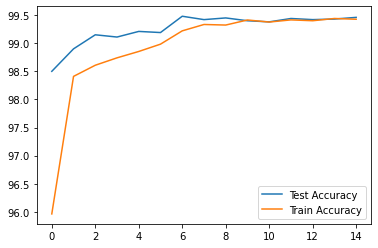

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

xaxis = list(range(len(test_acc)))
new_test_acc = [x*100.0 for x in test_acc]

plt.plot(xaxis, new_test_acc, label="Test Accuracy")
plt.plot(xaxis, train_acc, label="Train Accuracy")
plt.legend()
plt.show()

# Check which images were not predicted correctly

In [ ]:
rldd_model = Net()
rldd_model.load_state_dict(torch.load(base_folder+model_file_name+"_sd.pth"))

imgs = []
labels = []
preds = []
for img, target in test_loader:
  imgs.append( img )
  labels.append( target )
  preds.append( torch.argmax(rldd_model(img), dim=1) )

imgs = torch.cat(imgs, dim=0)
labels = torch.cat(labels, dim=0)
preds = torch.cat(preds, dim=0)

matches = preds.eq(labels)

In [ ]:
def create_plot_pos(nrows, ncols):
  num_images = nrows * ncols
  positions = []
  for r in range(num_images):
    row = r // ncols
    col = r % ncols
    positions.append((row, col))
  return positions

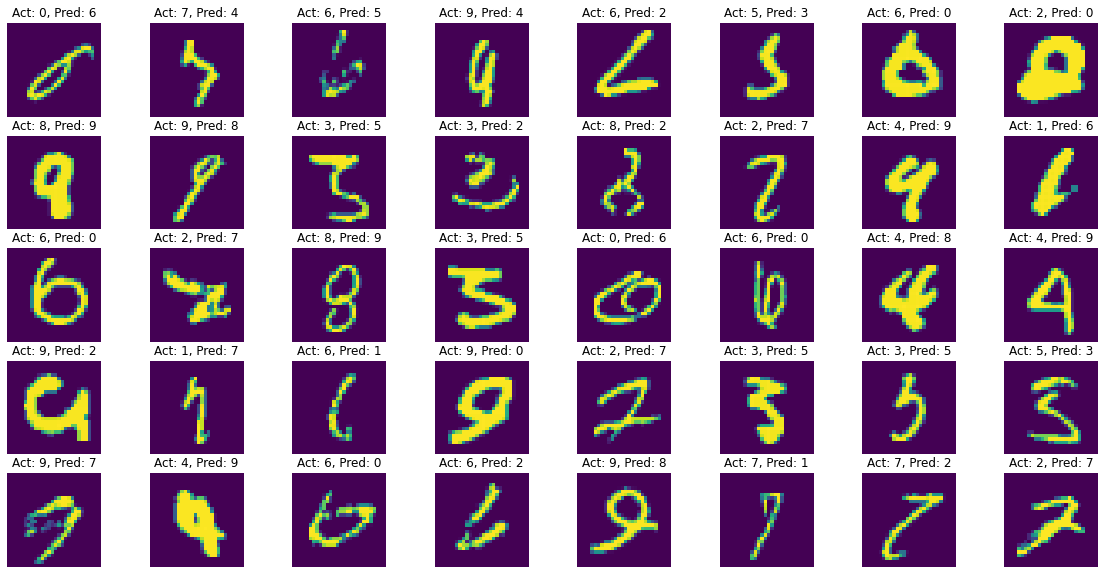

In [ ]:
idx = 0
nrows = 5
ncols = 8
skip = 25

total_imgs = nrows*ncols
pos = create_plot_pos(5, 8)

fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(20, 10), sharex=True, sharey=True)

idx = 0
posidx = 0
total_skipped = 0
for m in matches:
  if posidx > total_imgs-1:
    break

  if not m:
    if total_skipped <= skip:
      total_skipped += 1
      idx += 1
      continue

    img = imgs[idx].reshape(28,28)
    title = "Act: " + str(labels[idx].item()) + ", Pred: " + str(preds[idx].item())
    chart_pos = pos[posidx]
    axes[chart_pos].imshow(img)
    axes[chart_pos].set_title(title)
    axes[chart_pos].axis("off")

    posidx += 1
  
  idx += 1
